# Import the YOLOv8 pretrained model

- The model is pretrained (in another notebook)  using a Roboflow dataset version on OM images. 

In [21]:
from ultralytics import YOLO
from matplotlib import pyplot as plt
from PIL import Image
PYTORCH_NO_CUDA_MEMORY_CACHING=1

from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import torch
from torch import cuda
import os
import numpy as np
import random
from PIL import Image
import matplotlib.colors as mcolors
import numpy.ma as ma
import json
np.set_printoptions(precision=15)

torch.backends.cudnn.deterministic = True
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from typing import Any, Dict, Generator,List
import matplotlib.pyplot as plt
import numpy as np

from importlib import reload
import dataset_utils
reload(dataset_utils)
from dataset_utils import *

import predictor_utils
reload(predictor_utils)
from predictor_utils import *

import loss
reload(loss)
from loss import *

## Dataset (YOLOv8 format)

In [2]:
yolo_dataset_path = './xmm_om_images_v4-contrast-512-5-7-YOLO/'

In [3]:
import yaml
with open(yolo_dataset_path+"data.yaml", 'r') as stream:
    yam_data = yaml.safe_load(stream) # dict with keys 'names', 'nc', 'roboflow', 'test', 'train', 'val'
yam_data['names']

classes = {i:name for i, name in enumerate(yam_data['names'])}
train_path = yam_data['train']
val_path = yam_data['val']
test_path = yam_data['test']
print(classes)

{0: 'central-ring', 1: 'cluster', 2: 'galaxy', 3: 'nebula', 4: 'other', 5: 'read-out-streak', 6: 'scattered-light-outside-FOV', 7: 'smoke-ring', 8: 'star', 9: 'star-loop'}


In [4]:
# get masks from dataset (in YOLOv8 format) given an image file

def get_label_file_path(dataset_path, image_location):
    dataset_path = '/'.join(dataset_path.split('/')[:-2])+'/'+'labels'+'/'
    label_file_path = os.path.join(dataset_path, image_location)
    label_loc = '.'.join(image_location.split('.')[:-1]) + '.txt'
    label_file_path = dataset_path+label_loc
    return label_file_path

def read_annotations(label_file_path):
    annotations = []
    with open(label_file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            class_id = int(parts[0])
            segmentation_points = [float(p) for p in parts[1:]]
            annotations.append({
                'class_id': class_id,
                'segmentation_points': segmentation_points
            })
    return annotations

def get_masks_from_image(yolo_dataset_path, image_location):
    label_file_path = get_label_file_path(yolo_dataset_path, image_location)
    annotations = read_annotations(label_file_path)
    masks = [create_mask_0_1(annot['segmentation_points'], (512, 512)) for annot in annotations]
    return masks


**hyperparameters docs: https://docs.ultralytics.com/usage/cfg/#train**


image 1/1 /workspace/raid/OM_DeepLearning/XMM_OM_code_git/../XMM_OM_dataset/zscaled_512_stretched/S0005010301_L.png: 800x800 4 read-out-streaks, 1 smoke-ring, 8 stars, 2 star-loops, 120.9ms
Speed: 7.6ms preprocess, 120.9ms inference, 14.3ms postprocess per image at shape (1, 3, 800, 800)
torch.Size([15, 800, 800])
15


dict_values(['central-ring', 'cluster', 'galaxy', 'nebula', 'other', 'read-out-streak', 'scattered-light-outside-FOV', 'smoke-ring', 'star', 'star-loop'])

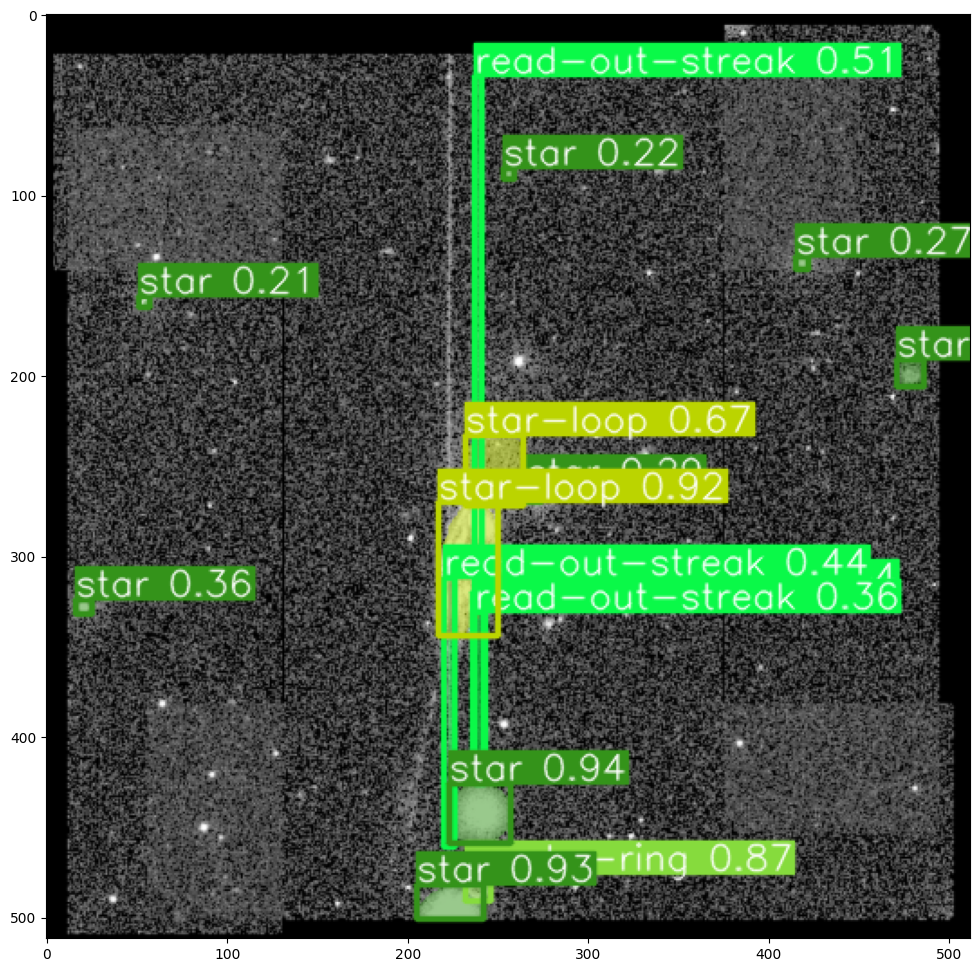

In [7]:
def show_masks(masks, ax, random_color=False):
    for mask in masks:
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        else:
                color = np.array([30/255, 144/255, 255/255, 0.6])
        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        ax.imshow(mask_image)
        
# # Instance
# model = YOLO('yolov8n-seg.yaml')  # build a new model from YAML
# model = YOLO('yolov8n-seg.pt')  # Transfer the weights from a pretrained model (recommended for training)
# # define number of classes based on YAML
# import yaml
# with open("./xmm_om_images_v4-contrast-512-5-7-YOLO/data.yaml", 'r') as stream:
#     num_classes = str(yaml.safe_load(stream)['nc'])
# print('num_classes', num_classes)
# # wandb project
# project = "yolov8-segm-fine-tuning"
# # subdirectory
# name = "200_epochs-m"
# # Train the model
# results = model.train(data='./xmm_om_images_v4-contrast-512-5-7-YOLO/data.yaml',
#                       project=project,
#                       name=name,
#                       epochs=200,
#                       patience=0, #I am setting patience=0 to disable early stopping.
#                       batch=4,
#                       imgsz=512,
#                       # augment=True, 
#                       # input custom augm and set the augm to None herte
#                       # freeze layers
#                       # try without mosaics
#                       # 
#                      )
yolov8_pretrained_model = YOLO('./yolov8-segm-fine-tuning/200_epochs-2/weights/best.pt')
yolov8_pretrained_model.to('cpu')
new_image = '../XMM_OM_dataset/zscaled_512_stretched/S0005010301_L.png'
new_results = yolov8_pretrained_model.predict(new_image, conf=0.2)  #Adjust conf threshold
new_result_array = new_results[0].plot()
plt.figure(figsize=(12, 12))
plt.imshow(new_result_array)
new_result = new_results[0]
# print(new_result.masks.xyn)
extracted_masks = new_result.masks.data
print(extracted_masks.shape)
masks_array = extracted_masks.cpu().numpy()
print(len(masks_array))
# plt.imshow(masks_array[0])
# plt.show()
# plt.close()
class_names = new_result.names.values()
class_names

In [8]:
extracted_masks.shape

torch.Size([15, 800, 800])

In [9]:
# Extract the boxes, which likely contain class IDs
detected_boxes = new_result.boxes.data
# Extract class IDs from the detected boxes
class_labels = detected_boxes[:, -1].int().tolist()
# Initialize a dictionary to hold masks by class
masks_by_class = {name: [] for name in new_result.names.values()}

# Iterate through the masks and class labels
for mask, class_id in zip(extracted_masks, class_labels):
    class_name = new_result.names[class_id]  # Map class ID to class name
    masks_by_class[class_name].append(mask.cpu().numpy())

In [10]:
detected_boxes

tensor([[2.2387e+02, 4.2614e+02, 2.5745e+02, 4.5978e+02, 9.3640e-01, 8.0000e+00],
        [2.0599e+02, 4.8289e+02, 2.4281e+02, 5.0186e+02, 9.2654e-01, 8.0000e+00],
        [2.1774e+02, 2.7099e+02, 2.5051e+02, 3.4452e+02, 9.1622e-01, 9.0000e+00],
        [2.3240e+02, 4.7692e+02, 2.4660e+02, 4.9146e+02, 8.7015e-01, 7.0000e+00],
        [2.3238e+02, 2.3310e+02, 2.6450e+02, 2.7203e+02, 6.7461e-01, 9.0000e+00],
        [4.7153e+02, 1.9168e+02, 4.8678e+02, 2.0631e+02, 6.2217e-01, 8.0000e+00],
        [2.3740e+02, 3.4661e+01, 2.4170e+02, 2.9791e+02, 5.1351e-01, 5.0000e+00],
        [2.2095e+02, 3.1228e+02, 2.2643e+02, 4.6132e+02, 4.3621e-01, 5.0000e+00],
        [1.6862e+01, 3.2475e+02, 2.5618e+01, 3.3252e+02, 3.6237e-01, 8.0000e+00],
        [2.3771e+02, 3.3126e+02, 2.4319e+02, 4.2602e+02, 3.6027e-01, 5.0000e+00],
        [2.3659e+02, 3.2085e+02, 2.4205e+02, 4.2419e+02, 3.3987e-01, 5.0000e+00],
        [2.6651e+02, 2.6262e+02, 2.7475e+02, 2.7029e+02, 2.8780e-01, 8.0000e+00],
        [4.1599e

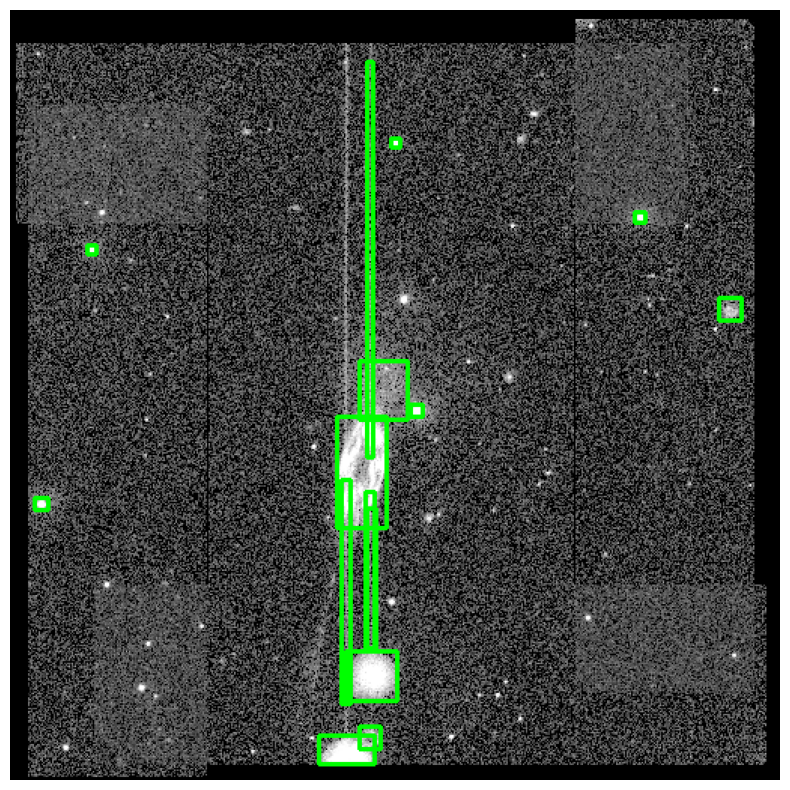

In [11]:
import cv2

image = image = cv2.imread(new_image)

for box in detected_boxes:
    # Convert tensor to numpy array for easier handling
    box = box.cpu().numpy()
    
    # Extract coordinates and dimensions
    # Adjust indices if your format is different
    x, y, width, height = int(box[0]), int(box[1]), int(box[2])-int(box[0]), int(box[3])-int(box[1])
    
    # Calculate the bottom-right corner
    end_x, end_y = x + width, y + height
    
    # Draw the rectangle on the image
    image = cv2.rectangle(image, (x, y), (end_x, end_y), (0, 255, 0), 2)  # Green color

# Convert BGR image to RGB for displaying with matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('off')  # Hide the axis
plt.show()

# Couple YOLO bboxes with SAM

In [12]:
dir_ = '/workspace/raid/OM_DeepLearning/MobileSAM-master/MobileSAMv2/'

def show_anns(anns):
    if len(anns) == 0:
        return
    ax = plt.gca()
    ax.set_autoscale_on(False)
    img = np.ones((anns.shape[1], anns.shape[2], 4))
    img[:,:,3] = 0
    for ann in range(anns.shape[0]):
        m = anns[ann].bool()
        m=m.cpu().numpy()
        color_mask = np.concatenate([np.random.random(3), [1]])
        img[m] = color_mask
    ax.imshow(img)

def batch_iterator(batch_size: int, *args) -> Generator[List[Any], None, None]:
    assert len(args) > 0 and all(
        len(a) == len(args[0]) for a in args
    ), "Batched iteration must have inputs of all the same size."
    n_batches = len(args[0]) // batch_size + int(len(args[0]) % batch_size != 0)
    for b in range(n_batches):
        yield [arg[b * batch_size : (b + 1) * batch_size] for arg in args]

**load SAM model**

In [13]:
import sys
import PIL
from PIL import Image

sys.path.append('/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/')
from ft_mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

mobile_sam_checkpoint = "/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/weights/mobile_sam.pt"
# device = "cuda:6" if torch.cuda.is_available() else "cpu"
device = 'cpu'
print("device:", device)

mobile_sam_model = sam_model_registry["vit_t"](checkpoint=mobile_sam_checkpoint)
mobile_sam_model.to(device);
images_dir = './xmm_om_images_v4-contrast-512-5-7-YOLO/train/images/'
image_files= os.listdir(images_dir)
predictor = SamPredictor(mobile_sam_model)

/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/ft_mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with ft_mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/ft_mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with ft_mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/ft_mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with ft_mobile_sam.modeling.tiny_vit_sam.tiny_vit_21m_224. This is because the name being registered conflicts with an existing na

device: cpu


In [88]:
import glob
from roboflow import Roboflow

rf = Roboflow(api_key="EBeK30tpU3HW2VGGl0xa")
upload_project = rf.workspace("orij").project("xmm_om_images_512_no_stars") # error if the project doesn't exist

def export_image_det_to_Roboflow(input_dir, filename, masks, obj_results):
    class_names = obj_results[0].names
    class_labels = obj_results[0].boxes.data[:, -1].int().tolist()
    
    objects = []
    for i in range(len(masks)):
        # masks[i]: [ 1, H, W]
        polygon = binary_image_to_polygon(masks[i].numpy()[0])
        bbox = mask_to_bbox(masks[i].numpy())
        if class_names[class_labels[i]] != 'star': # ignore stars
            objects.append({
                'name': class_names[class_labels[i]],
                'bbox': bbox,
                'segmentations': polygon[0]
            })
    if len(objects):
        create_annotation_SAM(filename=filename, width=512, height=512, depth=3, objects=objects) # generating xml file for VOC format
        image_path = input_dir+filename
        annotation_filename = filename.replace(".jpg", ".xml")
        upload_project.upload(image_path, annotation_filename, overwrite=True)
        os.remove(annotation_filename)

loading Roboflow workspace...
loading Roboflow project...


In [92]:
import time
start_time = time.time()
import torch.nn.functional as F

import loss
reload(loss)
from loss import *
from importlib import reload
import astronomy_utils, predictor_utils, voc_annotate_and_Roboflow_export
reload(astronomy_utils)
reload(predictor_utils)
reload(voc_annotate_and_Roboflow_export)

from predictor_utils import *
from astronomy_utils import *
from voc_annotate_and_Roboflow_export import * 

for image_name in image_files[:10]:
        print('*****', images_dir, image_name)
        image = cv2.imread(images_dir + image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        obj_results = yolov8_pretrained_model.predict(images_dir + image_name, conf=0.2)  # Adjust conf threshold
        predictor.set_image(image)
    
        gt_masks = get_masks_from_image(images_dir, image_name)
        if len(obj_results[0]) == 0:
            print(f"No masks for {image_name}.")
            plt.imshow(image)
            plt.show()
            plt.close()
            continue
        if len(gt_masks) == 0:
            print(f"No GT masks for {image_name}.")
            plt.imshow(image)
            plt.show()
            plt.close()
            continue
        input_boxes1 = obj_results[0].boxes.xyxy
        input_boxes = input_boxes1.cpu().numpy()
        input_boxes = predictor.transform.apply_boxes(input_boxes, predictor.original_size)
        input_boxes = torch.from_numpy(input_boxes).to(device)
        sam_mask, yolo_masks = [], []
        image_embedding=predictor.features
        prompt_embedding=mobile_sam_model.prompt_encoder.get_dense_pe()
        non_resized_masks = obj_results[0].masks.data.cpu().numpy()
        for i in range(len(non_resized_masks)):
                yolo_masks.append(cv2.resize(non_resized_masks[i], image.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)) 
    
        for (boxes,) in batch_iterator(320, input_boxes): 
            with torch.no_grad():
                image_embedding=image_embedding[0:boxes.shape[0],:,:,:]
                prompt_embedding=prompt_embedding[0:boxes.shape[0],:,:,:]
                sparse_embeddings, dense_embeddings = mobile_sam_model.prompt_encoder(
                    points=None,
                    boxes=boxes,
                    masks=None,)
                low_res_masks, _ = mobile_sam_model.mask_decoder(
                    image_embeddings=image_embedding,
                    image_pe=prompt_embedding,
                    sparse_prompt_embeddings=sparse_embeddings,
                    dense_prompt_embeddings=dense_embeddings,
                    multimask_output=False,
                )
                low_res_masks=predictor.model.postprocess_masks(low_res_masks, predictor.input_size, predictor.original_size)
                sam_mask_pre = (low_res_masks > mobile_sam_model.mask_threshold)*1.0
                sam_mask.append(sam_mask_pre.squeeze(1))

                # reshape gt_masks to same shape as predicted masks
                gt_masks_tensor = torch.stack([torch.from_numpy(mask).unsqueeze(0) for mask in gt_masks], dim=0)
                yolo_masks_tensor = torch.stack([torch.from_numpy(mask).unsqueeze(0) for mask in yolo_masks], dim=0)
                segm_loss_sam = segm_loss_match(sam_mask_pre, gt_masks_tensor)
                segm_loss_yolo = segm_loss_match(yolo_masks_tensor, gt_masks_tensor)

                print(f"Segmentation loss YOLO: {segm_loss_yolo.item()}.Segmentation loss SAM: {segm_loss_sam.item()} ")
                
                # optional: export new predictions to Roboflow in VOC format
                if segm_loss_sam < segm_loss_yolo:
                    export_image_det_to_Roboflow(images_dir, image_name, sam_mask_pre, obj_results)
                else:
                    export_image_det_to_Roboflow(images_dir, image_name, yolo_masks_tensor, obj_results)

                fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 
                
                # Plot 1: YOLO Masks
                axes[0].imshow(image)
                axes[0].set_title('YOLOv8n predicted Masks')
                show_masks(yolo_masks, axes[0], random_color=True)
                
                # Plot 2: Bounding Boxes
                image1 = cv2.resize(image, (1024, 1024))
                for bbox in boxes:
                    x1, y1, x2, y2 = bbox.detach().cpu().numpy()
                    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                    cv2.rectangle(image1, (x1, y1), (x2, y2), (0, 255, 0), 2) 
                image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
                axes[1].imshow(image1_rgb)
                axes[1].set_title('YOLOv8n predicted Bboxes')
                
                # Plot 3: SAM Masks
                sam_masks_numpy = sam_mask[0].detach().cpu().numpy()
                axes[2].imshow(image)
                show_masks(sam_masks_numpy, axes[2], random_color=True)
                axes[2].set_title('MobileSAM predicted masks')
                plt.tight_layout() 
                plt.savefig(f'./plots/combined_plots{i}.png')
                plt.show()
                
print(f"Execution time: {time.time()- start_time} seconds")

***** ../XMM_OM_dataset/zscaled_512_stretched/ S0670140301_M.png

image 1/1 /workspace/raid/OM_DeepLearning/XMM_OM_code_git/../XMM_OM_dataset/zscaled_512_stretched/S0670140301_M.png: 800x800 8 stars, 109.0ms
Speed: 3.3ms preprocess, 109.0ms inference, 6.1ms postprocess per image at shape (1, 3, 800, 800)


FileNotFoundError: [Errno 2] No such file or directory: '../XMM_OM_dataset/labels/S0670140301_M.txt'

In [ ]:
obj_results[0].masks.shape

In [2]:
# import json 
# import os
# import tarfile

# second_directory_path = '../XMM_OM_dataset/zscaled_512_stretched/'
# archive_name = 'imgs_512_50.tar.gz'

# files_to_archive = []
# for file in os.listdir(second_directory_path):
#         files_to_archive.append(os.path.join(second_directory_path, file))

# files_to_archive = files_to_archive[500:550]
# # Create a tar.gz archive of the filtered files
# with tarfile.open(archive_name, "w:gz") as tar:
#     for file_path in files_to_archive:
#         tar.add(file_path, arcname=os.path.basename(file_path))

# print(f"Archive {archive_name} created with {len(files_to_archive)} files.")